## Лабораторная работа 4
#### Выполнил: Граур Арсений `5130901/10203`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ThinkDSP.code.thinkdsp import decorate

### Упражнение 1

Я выбрал звук толпы

In [20]:
from ThinkDSP.code.thinkdsp import read_wave

wave = read_wave('ThinkDSP/code/180929__docquesting__crowd-noise.wav')
wave.make_audio()

c:\Users\argraur\Projects\telecom\labs\ThinkDSP\code\thinkdsp.py:1113: RuntimeWarning: overflow encountered in scalar absolute
  high, low = abs(max(ys)), abs(min(ys))


Выберем небольшой сегмент

In [21]:
segment = wave.segment(start=3, duration=1.0)
segment.make_audio()

Спектр

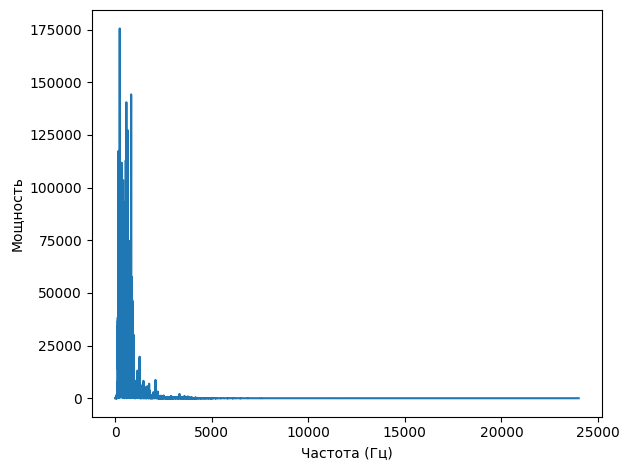

In [22]:
spectrum = segment.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Частота (Гц)',
         ylabel='Мощность')

Выведем спектр мощности

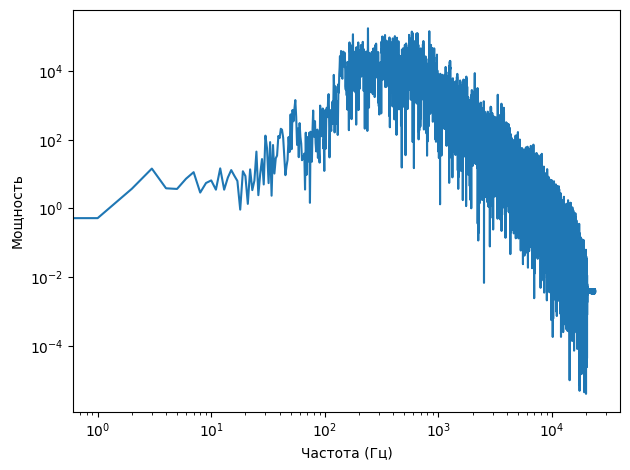

In [23]:
spectrum.plot_power()

loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Частота (Гц)',
         ylabel='Мощность', 
         **loglog)

Судя по графику, больше всего шум похож на розовый

In [24]:
spectrum.estimate_slope()[0]

-3.6396586999027574

Посмотрим как спектр меняется со временем

In [25]:
segment2 = wave.segment(start=15, duration=1.0)
segment2.make_audio()

Выведем для наглядности сразу два спектра мощности

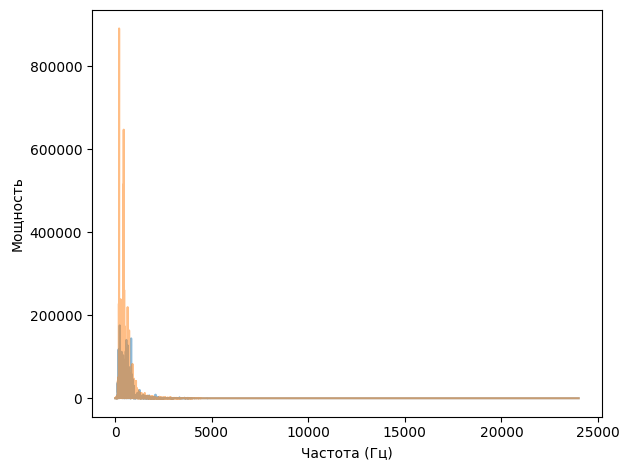

In [26]:
spectrum2 = segment2.make_spectrum()

spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частота (Гц)',
         ylabel='Мощность')

In [27]:
spectrum2.estimate_slope()[0]

-3.5283151236501613

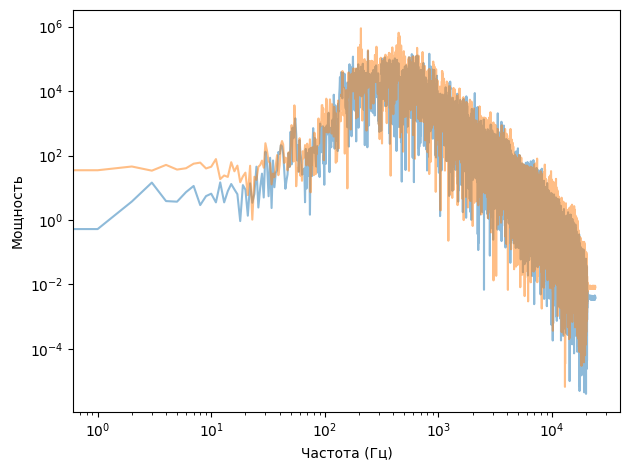

In [28]:
spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Частота (Гц)',
         ylabel='Мощность',
         **loglog)

Судя по полученным результатам, спектр остается почти одинаковым на всем промежутке времени.

### Упражнение 2

In [13]:
from ThinkDSP.code.thinkdsp import Spectrum

def bartlett_method(wave, seg_length=512, win_flag=True):
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()
    
    psds = [spectrum.power for spectrum in spectrums]
    
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

Применим этот метод на созданных ранее сегментах

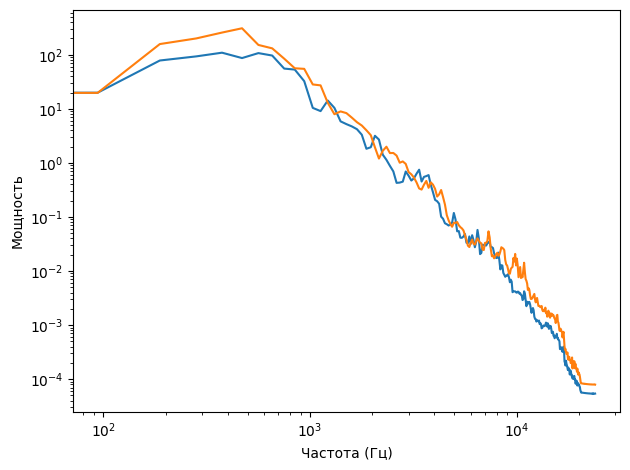

In [14]:
psd = bartlett_method(segment)
psd2 = bartlett_method(segment2)

psd.plot_power()
psd2.plot_power()

decorate(xlabel='Частота (Гц)', 
         ylabel='Мощность', 
         **loglog)

Теперь можно намного нагляднее увидеть зависимость мощности от частоты

### Упражнение 3

In [29]:
import pandas as pd

df = pd.read_csv('ThinkDSP/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])
df

Currency        Date  Closing Price (USD)  24h Open (USD)  \
0         BTC  2013-10-01           123.654990      124.304660   
1         BTC  2013-10-02           125.455000      123.654990   
2         BTC  2013-10-03           108.584830      125.455000   
3         BTC  2013-10-04           118.674660      108.584830   
4         BTC  2013-10-05           121.338660      118.674660   
...       ...         ...                  ...             ...   
2354      BTC  2020-03-22          5884.340133     6187.042146   
2355      BTC  2020-03-23          6455.454688     5829.352511   
2356      BTC  2020-03-24          6784.318011     6455.450650   
2357      BTC  2020-03-25          6706.985089     6784.325204   
2358      BTC  2020-03-26          6721.495392     6697.948320   

      24h High (USD)  24h Low (USD)  
0         124.751660     122.563490  
1         125.758500     123.633830  
2         125.665660      83.328330  
3         118.675000     107.058160  
4         121.936330     118.005660  
...              ...            ...  
2354     6431.873162    5802.553402  
2355     6620.858253    5694.198299  
2356     6863.602196    6406.037439  
2357     6981.720386    6488.111885  
2358     6796.053701    6537.856462  

[2359 rows x 6 columns]

In [30]:
ys = df['Closing Price (USD)']
ts = df.index

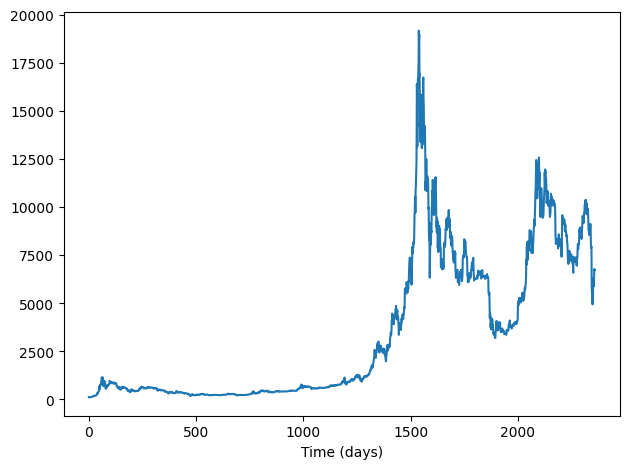

In [31]:
from ThinkDSP.code.thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)')

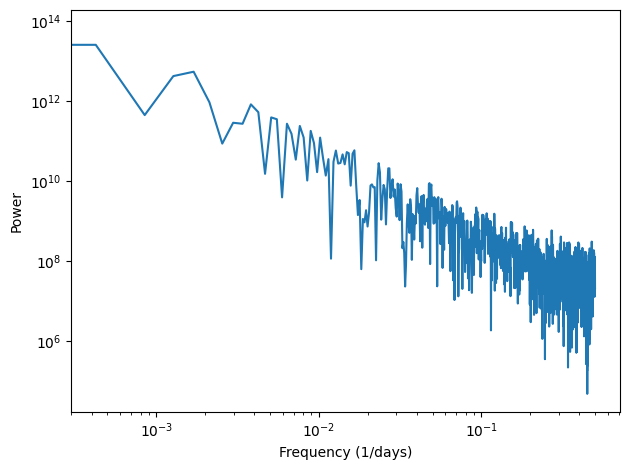

In [32]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (1/days)',
         ylabel='Power', 
         **loglog)

In [33]:
spectrum.estimate_slope()[0]

-1.7332540936758956

Сложно сказать это красный шум или все-таки разновидность розового

### Упражнение 4

In [34]:
from ThinkDSP.code.thinkdsp import Noise

class UncorrelatedPoissonNoise(Noise):
    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Этот класс наследуется от базового класса Noise и переопределяет метод evaluate, который генерирует последовательность случайных чисел, следующих пуассоновскому распределению, для имитации шума.

In [37]:
amp = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

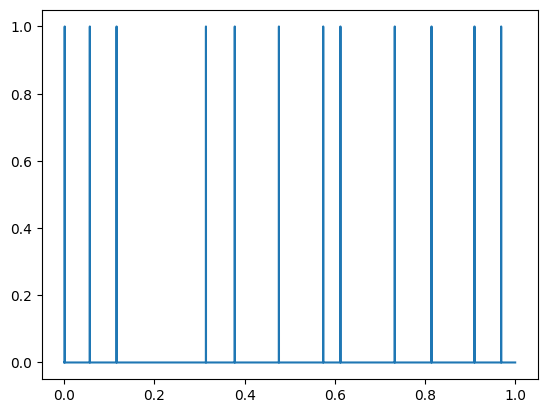

In [38]:
wave.plot()

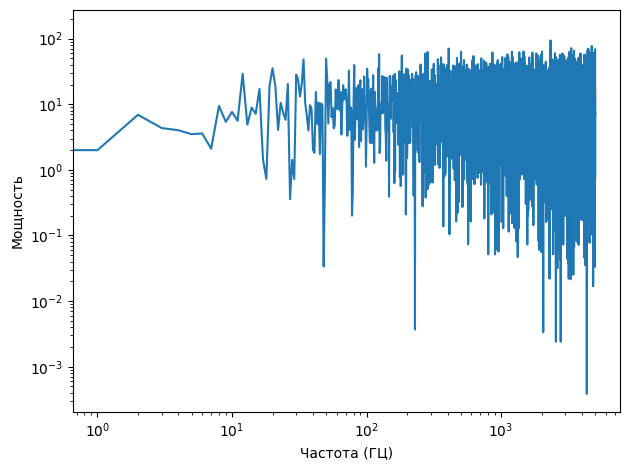

In [39]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Частота (ГЦ)',
         ylabel='Мощность',
         **loglog)

Это белый шум

In [40]:
spectrum.estimate_slope().slope

-0.0060985067456855585

### Упражнение 5

Напишем функцию алгоритма Voss-McCartney для генерации розового шума. Также проверим его и выведем получившийся звук.

In [41]:
def voss(nrows, ncols=16):
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

C:\Users\argraur\AppData\Local\Temp\ipykernel_46932\1170444218.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


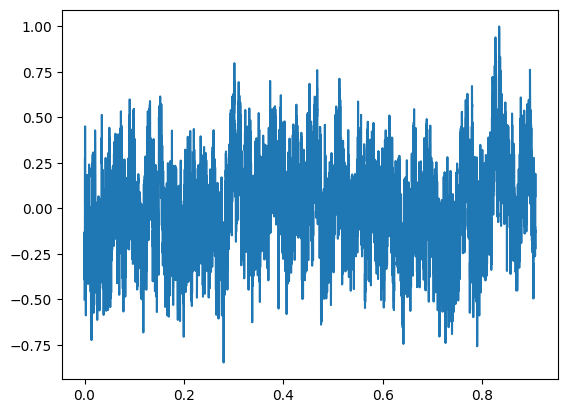

In [44]:
wave = Wave(voss(10000))
wave.unbias()
wave.normalize()
wave.plot()

In [45]:
wave.make_audio()

Выведем спектр

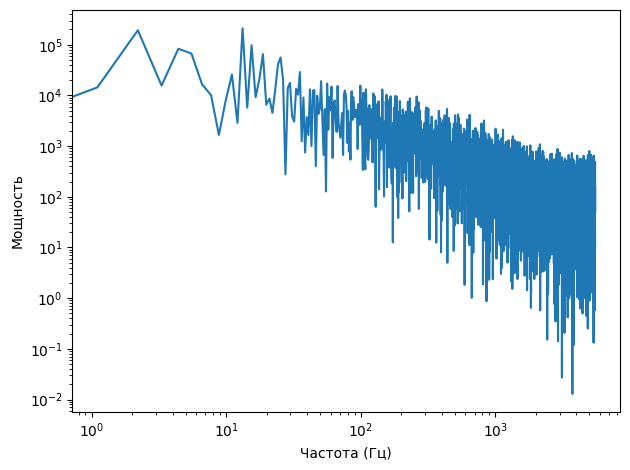

In [47]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Частота (Гц)',
         ylabel='Мощность',
         **loglog)

In [48]:
spectrum.estimate_slope().slope

-0.9680150896695808

В итоге, судя по графику, мы смогли получить шум очень похожий на розовый шум.